In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.stats import t
import pandas as pd
from numpy import random

In [7]:
class MRLS:
 
    def __init__(self, x, y, ajuste=0):
      self.x=x-ajuste
      self.y=y
      self.n=np.shape(self.x)[0]
      self.ybarra=self.y.mean()  
      self.xbarra=self.x.mean()    
      self.Qmres=False
      self.Sqres=False
      self.Sqt=False
      self.Sqreg=False
      self.Sxx=False
      self.Sxy=False
      self.beta0=False
      self.beta1=False
      self.var=False
      self.ynew=np.zeros((self.n), dtype=bool)
      self.matrizCov=False
      self.pvalor=False
      self.test=False
 

#teste de H0:beta1=0
    def valorp(self):
        if(not self.Sqreg):
          MRLS.MSqreg(self)
        if(not self.Qmres):
          MRLS.MQmres(self)
        F=self.Sqreg/self.Qmres
        print("F=", F)
        self.pvalor=1-f.cdf(F, 1, self.n-2)
        if(self.pvalor<0.05):
           test=0 #rejeito H0
        else:
           test=1 #aceito H0
        return test
 
 
#teste de H0:beta0=0
    def Teste(self): 
        if(not self.Sxx):
            MRLS.MSxx(self)
        if(not self.Sxy):
            MRLS.MSxy(self)
        beta1=(self.Sxy)/(self.Sxx)
        beta0=(self.ybarra)-(beta1)*(self.xbarra)
        ynew=beta0+(beta1)*(self.x)
        ynew=ynew.reshape(-1)
        Sqres=(np.linalg.norm(self.y-ynew,ord=2))**2
        Qmres=Sqres/(self.n-2)
        t0=beta0/(Qmres*((1/(self.n))+((self.xbarra)**2)/(self.Sxx)))**(1/2)
        aux=[t.cdf(t0, self.n-2),1-t.cdf(t0, self.n-2)]
        #print(aux)
        self.pvalor0=2*(np.min(aux))
        if(self.pvalor0<0.05):
           self.test=99 #rejeito H0
        else:
           self.test=True #aceito H0
           self.beta0=0
        return self.pvalor0
 
 
    def MSqreg(self):
        if(not self.test):
            MRLS.Teste(self)
        if(not self.ynew.any()):
             MRLS.Mynew(self)
        if(self.test==99):
        #modelo com intercepto
           self.Sqreg=(np.linalg.norm(self.ynew-self.ybarra, ord=2)**2)
        else:
           self.Sqreg=(np.linalg.norm(self.ynew, ord=2)**2)
        return self.Sqreg
  
 
    def MSqt(self):
        if(not self.test):
            MRLS.Teste(self)
        if(self.test==99):
          # modelo com intercepto
          self.Sqt=(np.linalg.norm(self.y-self.ybarra, ord=2))**2
        else:
          self.Sqt=(np.linalg.norm(self.y, ord=2))**2
        return self.Sqt
 
 
    def MQmres(self):
        if(not self.test):
            MRLS.Teste(self)
        if(not self.Sqres):
          MRLS.MSqres(self)
        if(self.test==99):
          self.Qmres=self.Sqres/(self.n-2)
        else:
          self.Qmres=self.Sqres/(self.n-1)
        return self.Qmres
 
 
    def MSqres(self):
        if(not self.ynew.any()):
          MRLS.Mynew(self)
        self.Sqres=(np.linalg.norm(self.y-self.ynew,ord=2))**2
        return self.Sqres
 
 
    def MSxx(self):
        self.Sxx=0
        for i in range(self.n):
           self.Sxx+=(self.x[i]-self.xbarra)**2
        return self.Sxx
 
 
    def MSxy(self):
        self.Sxy=0        
        for i in range(self.n):
           self.Sxy+=(self.y[i]-self.ybarra)*self.x[i]
        return self.Sxy
 
 
    def Mbeta0(self):
        if(not self.beta1):
           MRLS.Mbeta1(self)
        self.beta0=(self.ybarra)-(self.beta1)*(self.xbarra)
        MRLS.Teste(self)
        return self.beta0
 
 
    def Mbeta1(self):
      if(not self.test):
            MRLS.Teste(self)
      if(self.test==99):
         if(not self.Sxy): 
             MRLS.MSxy(self)    
         if(not self.Sxx):   
             MRLS.MSxx(self)            
         self.beta1=(self.Sxy)/(self.Sxx)
      else:
         self.beta1=((self.x)@(self.y))/((self.x)@(self.x))
      return self.beta1
    
 
    def Mvar(self):
        if(not self.Qmres):
          MRLS.MQmres(self)
        self.var=self.Qmres
        return self.var
        
        
    def Mynew(self):
        if(not self.beta0):
           MRLS.Mbeta0(self)
        if(not self.beta1):
           MRLS.Mbeta1(self)
        if(not self.test):
            MRLS.Teste(self)
        k=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
        self.ynew=(self.beta0)+(self.beta1)*(self.x)
        self.ynew=self.ynew.reshape(-1)
        return self.ynew
 
 
    def CoefDet(self):
        if(not self.Sqreg):
          MRLS.MSqreg(self)
        if(not self.Sqt):
          MRLS.MSqt(self)
        return self.Sqreg/self.Sqt
 
 
    def MatrizCov(self):
         if(not self.Qmres):
            MRLS.MQmres(self)
         if(not self.Sxx):
            MRLS.MSxx(self)
         if(not self.test):  
            MRLS.Teste(self)
         if(self.test==99):
            Cov=np.zeros((2,2))
            Cov[0,0]=self.Qmres*(1/self.n+(self.xbarra**2)/self.Sxx)
            Cov[1,0]=Cov[0,1]=(-self.Qmres*self.xbarra)/self.Sxx
            Cov[1,1]=self.Qmres/self.Sxx
         else:
            Cov=self.var/((self.x)@(self.x))
         return Cov
    
 
    def Anova(self):
         if(not self.Sqreg):
             MRLS.MSqreg(self)
         if(not self.Sqt):
             MRLS.MSqt(self)
         if(not self.Sqres):
             MRLS.MSqres(self)
         E=np.zeros((3, 3))
         #GL
         E[0,0]=1
         E[1,0]=self.n-2
         E[2,0]=self.n-1
         #SQ
         E[0,1]=self.Sqreg
         E[1,1]=self.Sqres
         E[2,1]=self.Sqt
         #QM
         E[0,2]=self.Sqreg       
         E[1,2]=self.Sqres/(self.n-2)
         E[2,2]=self.Sqt/(self.n-1)
         coluna='GL SQ QM'.split()
         linha='Regressao Residuo Total'.split()
         anova=pd.DataFrame(data=E, index=linha, columns=coluna)
         return anova

beta0: [6.46551555]
beta1: [-0.34723781]
R^2: 0.3771618207393636
F= 1.8166604101907555
não há regressão


,GL,SQ,QM
Regressao,1.0,9.078530,9.078530
Residuo,3.0,14.992119,4.997373
Total,4.0,24.070649,6.017662


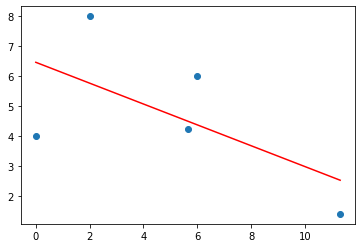

In [9]:
aux1=y=np.array([4, 8, 3*2**(1/2), 6, 2**(1/2)])
aux=x=np.array([0,  2, 4*2**(1/2), 6, 8*2**(1/2)])
#aux1=y=random.randint(50, 200, 10)
#aux=x=random.randint(50, 200, 10)
x=x.reshape(-1,1)
 
#obs:
 
#(1) nao chame atributos, mas sim os metodos
#que calculam os atributos
 
#(2) caso acha centralização do modelo
#especifique no terceiro parametro
#na definição do MRLS
#EXEMPLO: regresso=MRLS(x,y,b)
#o modelo será centralizado em b
teste=MRLS(x,y)
print("beta0:",teste.Mbeta0())
print("beta1:",teste.Mbeta1())
print("R^2:", teste.CoefDet())
#print("ah=", teste.valorp)
if(teste.valorp()==1):
   print("não há regressão")
#print("Sqreg:", teste.MSqreg())
#print("Qmres:", teste.MQmres())
#print("Sqres:", teste.MSqres())
#print("Sqt:", teste.MSqt())
#print("xbarra:", teste.xbarra)
#print("Sxx:", teste.MSxx())
plt.scatter(x,y)
plt.plot(x,teste.Mynew(), "red")
teste.Anova()